**Logistic regression analysis with ADAM optimization for different learning rates, regularization types, and regularization parameters.**

In [19]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import martine.functions_martine as fun
import martine.NeuralNetwork as NN
import pandas as pd

from pathlib import Path
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions.make_dataset import *
from functions.nn_pytorch import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset ##
from sklearn.preprocessing import LabelEncoder

import autograd.numpy as np
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import * 

import matplotlib.style as mplstyle

mplstyle.use(["ggplot", "fast"])

In [20]:
np.random.seed(2018)
seed = 2018

In [35]:
# get data set for own network

path = '/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/weather-type-classification/versions/1/weather_classification_data.csv'
data = pd.read_csv(path)

K = 4 # number of classes

# Identify categorical columns
cat_cols = data.select_dtypes(include=["object"]).columns

# Create label encoders for each categorical column
encoders = {col: LabelEncoder() for col in cat_cols}

# Apply encoding
# String to numerical conversion
for col in cat_cols:
    data[col] = encoders[col].fit_transform(data[col]).astype(int)

X = data.drop('Weather Type', axis=1).values
y = data['Weather Type'].values

# convert to/form? one-hot
inputs = X
targets = np.zeros((len(y), K))
for i, t in enumerate(y):
    targets[i, t] = 1

# split data into training and test data
X_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)

# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# get data for PyTorch

### **Testing different learning rates and regularization parameters**

**Own NN (Martine)**

In [ ]:
# set parameters
epochs = 50
M = 64
rho1, rho2 = 0.9, 0.999

netas = 4 #number of different learning rates
etas = np.logspace(-4, -1, netas)

nlambdas = 4 #number of different regularization parameters
lambdas = np.logspace(-6, -3, nlambdas)

In [ ]:
# vary learning rate (no regularization)

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([netas])
acc_test_matrix_no_reg = np.zeros([netas]) 

# define network architecture
network_input_size = X_train.shape[1]
layer_output_sizes1 = [K]

hidden_func = None
output_func = fun.Softmax()
cost_func = fun.CCE()

# create model object
model = NN.NeuralNetwork(network_input_size, layer_output_sizes1, hidden_func, output_func, cost_func, seed = seed)

activation_funcs = model.activation_list()

# loop through learning rates
for i in range(netas):
    eta = etas[i]

    # set learning rate scheduler
    scheduler = fun.ADAM(eta, rho1, rho2)

    # create/reset layers
    layers = model.create_layers()

    # train network using only training data and stochastic gradient descent
    updated_layers = model.train_network_SGD(X_train, layers, activation_funcs, t_train, scheduler, epochs, M)

    # evaluate model on training and test data
    train_metrics = model.evaluate(X_train, updated_layers, activation_funcs, t_train)
    test_metrics = model.evaluate(X_test, updated_layers, activation_funcs, t_test)
        
    # calculate accuracy score
    acc_train_matrix_no_reg[i] = train_metrics["accuracy"] #fill in accuracy for training data
    acc_test_matrix_no_reg[i] = test_metrics["accuracy"] #fill in accuracy for test data

ADAM: Learning rate = 0.0001, Regularization parameter = 0.0
ADAM: Learning rate = 0.001, Regularization parameter = 0.0
ADAM: Learning rate = 0.01, Regularization parameter = 0.0
ADAM: Learning rate = 0.1, Regularization parameter = 0.0


In [ ]:
# vary regularization parameter and learning rate (L2 regularization)

# matrices for storing accuracy results
acc_train_matrix_L2 = np.zeros([netas,nlambdas])
acc_test_matrix_L2 = np.zeros([netas,nlambdas]) 

# define network architecture
network_input_size = X_train.shape[1]
layer_output_sizes1 = [K]

hidden_func = None
output_func = fun.Softmax()
cost_func = fun.CCEL2()

# create model object
model = NN.NeuralNetwork(network_input_size, layer_output_sizes1, hidden_func, output_func, cost_func, seed = seed)

activation_funcs = model.activation_list()

# loop through learning rates and regularization parameters
for i in range(netas):
    for j in range(nlambdas):
        
        lmb = lambdas[j]
        eta = etas[i]

        # set learning rate scheduler
        scheduler = fun.ADAM(eta, rho1, rho2)

        # create/reset layers
        layers = model.create_layers()

        # train network using only training data and stochastic gradient descent
        updated_layers = model.train_network_SGD(X_train, layers, activation_funcs, t_train, scheduler, epochs, M, lmb)

        # evaluate model on training and test data
        train_metrics = model.evaluate(X_train, updated_layers, activation_funcs, t_train)
        test_metrics = model.evaluate(X_test, updated_layers, activation_funcs, t_test)
        
        # calculate accuracy score
        acc_train_matrix_L2[i,j] = train_metrics["accuracy"] #fill in accuracy for training data
        acc_test_matrix_L2[i,j] = test_metrics["accuracy"] #fill in accuracy for test data


ADAM: Learning rate = 0.0001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.0001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.0001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.0001, Regularization parameter = 0.001
ADAM: Learning rate = 0.001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.001, Regularization parameter = 0.001
ADAM: Learning rate = 0.01, Regularization parameter = 1e-06
ADAM: Learning rate = 0.01, Regularization parameter = 1e-05
ADAM: Learning rate = 0.01, Regularization parameter = 0.0001
ADAM: Learning rate = 0.01, Regularization parameter = 0.001
ADAM: Learning rate = 0.1, Regularization parameter = 1e-06
ADAM: Learning rate = 0.1, Regularization parameter = 1e-05
ADAM: Learning rate = 0.1, Regularization parameter = 0.0001
ADAM: Learning rate = 0.1, Regularization parameter = 0.001


In [ ]:
# vary regularization parameter and learning rate (L1 regularization)

# matrices for storing accuracy results
acc_train_matrix_L1 = np.zeros([netas,nlambdas])
acc_test_matrix_L1 = np.zeros([netas,nlambdas]) 

# define network architecture
network_input_size = X_train.shape[1]
layer_output_sizes1 = [K]

hidden_func = None
output_func = fun.Softmax()
cost_func = fun.CCEL1()

# create model object
model = NN.NeuralNetwork(network_input_size, layer_output_sizes1, hidden_func, output_func, cost_func, seed = seed)

activation_funcs = model.activation_list()

# loop through learning rates and regularization parameters
for i in range(netas):
    for j in range(nlambdas):
        
        lmb = lambdas[j]
        eta = etas[i]

        # set learning rate scheduler
        scheduler = fun.ADAM(eta, rho1, rho2)

        # create/reset layers
        layers = model.create_layers()

        # train network using only training data and stochastic gradient descent
        updated_layers = model.train_network_SGD(X_train, layers, activation_funcs, t_train, scheduler, epochs, M, lmb)

        # evaluate model on training and test data
        train_metrics = model.evaluate(X_train, updated_layers, activation_funcs, t_train)
        test_metrics = model.evaluate(X_test, updated_layers, activation_funcs, t_test)
        
        # calculate accuracy score
        acc_train_matrix_L1[i,j] = train_metrics["accuracy"] #fill in accuracy for training data
        acc_test_matrix_L1[i,j] = test_metrics["accuracy"] #fill in accuracy for test data


ADAM: Learning rate = 0.0001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.0001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.0001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.0001, Regularization parameter = 0.001
ADAM: Learning rate = 0.001, Regularization parameter = 1e-06
ADAM: Learning rate = 0.001, Regularization parameter = 1e-05
ADAM: Learning rate = 0.001, Regularization parameter = 0.0001
ADAM: Learning rate = 0.001, Regularization parameter = 0.001
ADAM: Learning rate = 0.01, Regularization parameter = 1e-06
ADAM: Learning rate = 0.01, Regularization parameter = 1e-05
ADAM: Learning rate = 0.01, Regularization parameter = 0.0001
ADAM: Learning rate = 0.01, Regularization parameter = 0.001
ADAM: Learning rate = 0.1, Regularization parameter = 1e-06
ADAM: Learning rate = 0.1, Regularization parameter = 1e-05
ADAM: Learning rate = 0.1, Regularization parameter = 0.0001
ADAM: Learning rate = 0.1, Regularization parameter = 0.001


C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_24268\3694056463.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


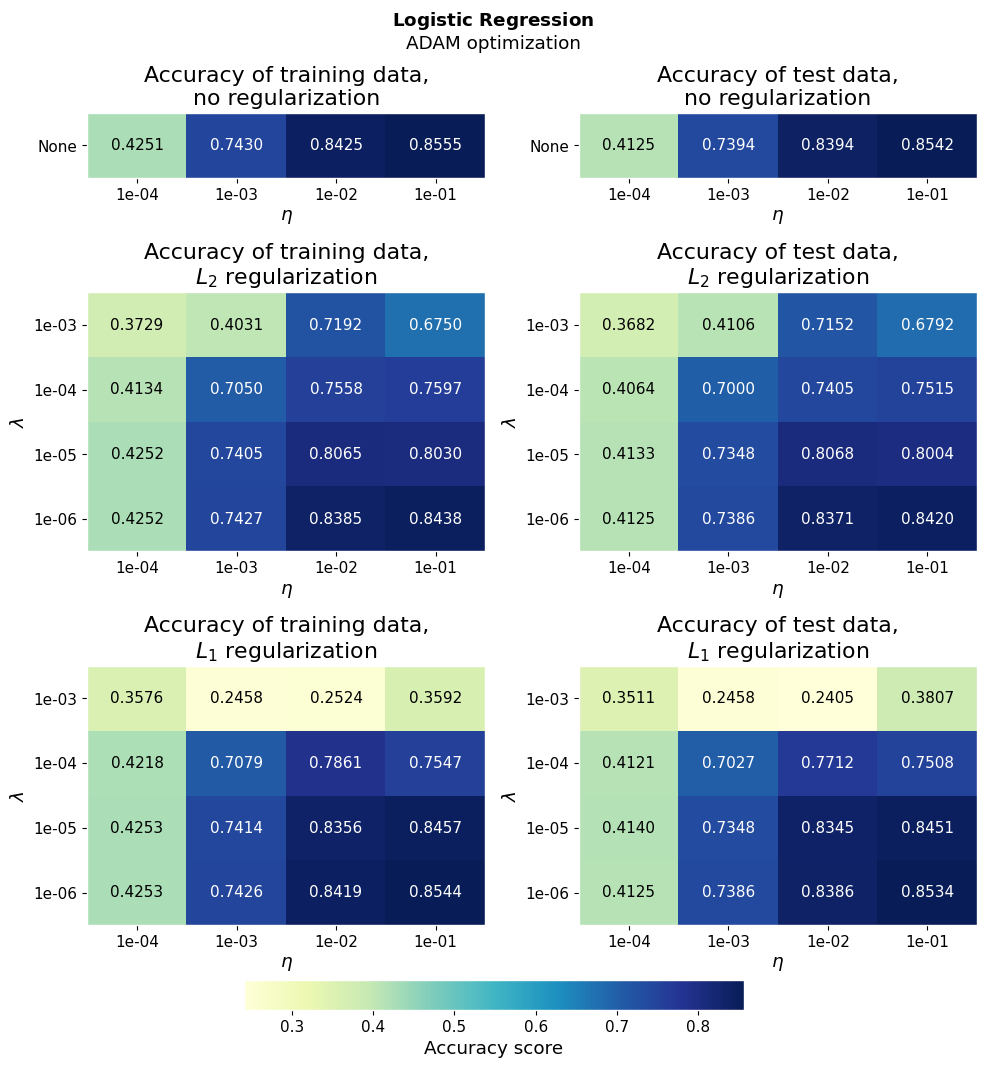

In [ ]:
# plot results

plt.rcParams.update({"font.size": 11})
plt.rcParams['axes.grid'] = False

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    ax.tick_params(colors="black")

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$", color = "black")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$", color = "black")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score", color = "black")
cbar.ax.tick_params(color = "black", labelcolor='black')

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()


**Own NN (Kjersti & Sverre)**

In [4]:
def accuracy(model, X, t):
    """
    Compute accuracy score
    """
    predictions = model._feed_forward(X)
    pred_class = np.argmax(predictions, axis=1)
    true_class = np.argmax(t, axis=1)
    return np.mean(pred_class == true_class)

In [ ]:
# vary learning rate (no regularization)

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([netas])
acc_test_matrix_no_reg = np.zeros([netas]) 

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]


# loop through learning rates
for i in range(netas):
    eta = etas[i]

    # Create a new network
    nn = NeuralNetwork(
        network_input_size=input_size,
        layer_output_sizes=layer_sizes,
        activation_funcs=activation_funcs,
        activation_ders=activation_ders,
        cost_fun=cross_entropy,
        cost_der=cross_entropy_der
    )

    # Train model using SGD and ADAM optimizer
    nn.train_SGD(
        X_train,
        t_train,
        epochs=epochs,
        learning_rate=eta,
        batch_size=M,
        optimizer="Adam"
    )

    # evaluate model on training and test data
    acc_train_matrix_no_reg[i] = accuracy(nn, X_train, t_train)
    acc_test_matrix_no_reg[i] = accuracy(nn, X_test, t_test)


In [ ]:
# vary regularization parameter and learning rate (L2 regularization)

# matrices for storing accuracy results
acc_train_matrix_L2 = np.zeros([netas,nlambdas])
acc_test_matrix_L2 = np.zeros([netas,nlambdas]) 

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        # Create a new network
        nn = NeuralNetwork(
            network_input_size = input_size,
            layer_output_sizes = layer_sizes,
            activation_funcs = activation_funcs,
            activation_ders = activation_ders,
            cost_fun = cross_entropy,
            cost_der = cross_entropy_der,
            lamb = lmb,
            cost_fun_type = "L2"
        )

        # Train model using SGD and ADAM optimizer
        nn.train_SGD(
            X_train,
            t_train,
            epochs = epochs,
            learning_rate = eta,
            batch_size = M,
            optimizer = "Adam"
        )

        # evaluate model on training and test data
        acc_train_matrix_L2[i, j] = accuracy(nn, X_train, t_train)
        acc_test_matrix_L2[i, j]  = accuracy(nn, X_test,  t_test)


In [ ]:
# vary regularization parameter and learning rate (L1 regularization)

# matrices for storing accuracy results
acc_train_matrix_L1 = np.zeros([netas,nlambdas])
acc_test_matrix_L1 = np.zeros([netas,nlambdas]) 

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        # Create a new network
        nn = NeuralNetwork(
            network_input_size = input_size,
            layer_output_sizes = layer_sizes,
            activation_funcs = activation_funcs,
            activation_ders = activation_ders,
            cost_fun = cross_entropy,
            cost_der = cross_entropy_der,
            lamb = lmb,
            cost_fun_type = "L1"
        )

        # Train model using SGD and ADAM optimizer
        nn.train_SGD(
            X_train,
            t_train,
            epochs = epochs,
            learning_rate = eta,
            batch_size = M,
            optimizer = "Adam"
        )

        # evaluate model on training and test data
        acc_train_matrix_L1[i, j] = accuracy(nn, X_train, t_train)
        acc_test_matrix_L1[i, j]  = accuracy(nn, X_test,  t_test)

C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_17128\1895987452.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


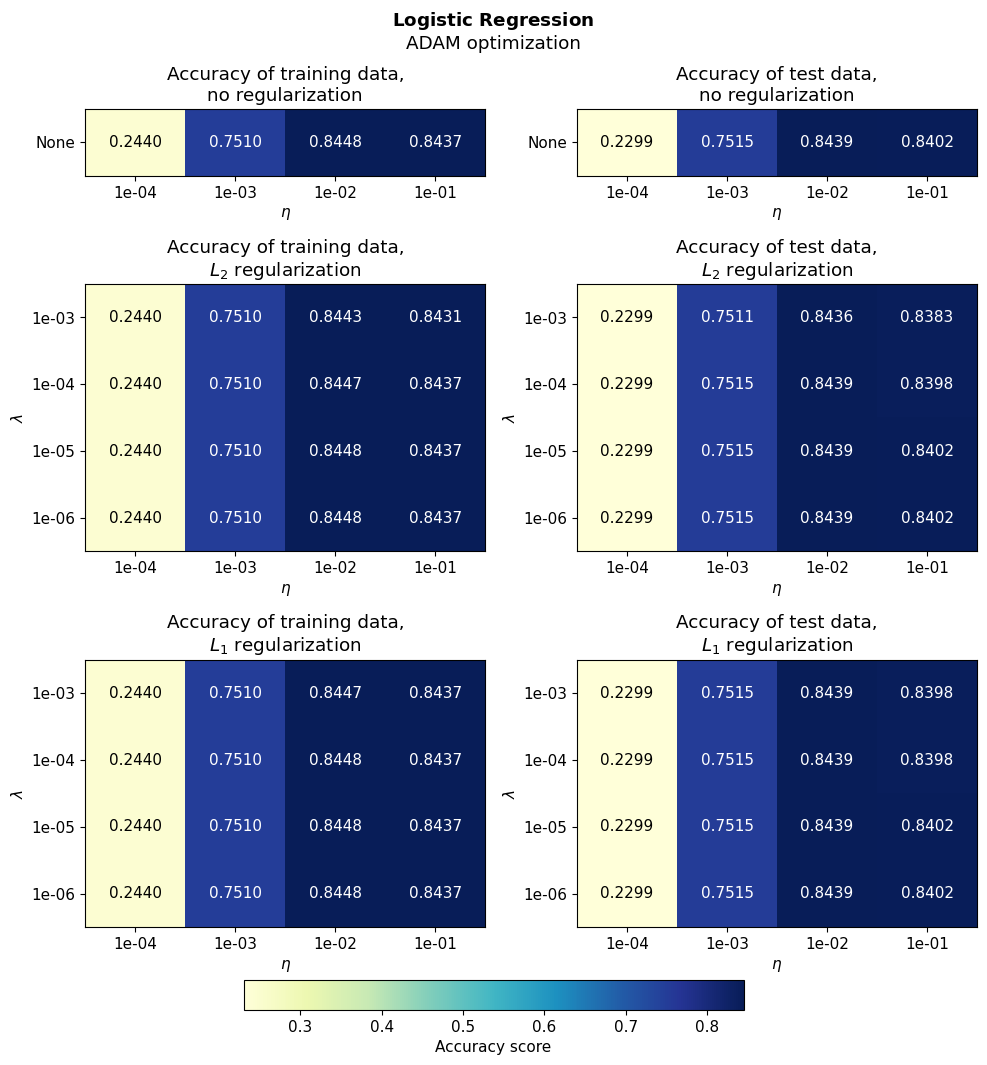

In [ ]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()


**Pytorch**

In [ ]:
path = '/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/weather-type-classification/versions/1/weather_classification_data.csv'
dataset = WeatherDataset(csv_file=path)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
    
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [16]:
"""
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(t_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(t_test))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
"""

'\nfrom torch.utils.data import DataLoader, TensorDataset\n\nX_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)\n\ntrain_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(t_train))\ntest_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(t_test))\n\ntrain_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)\ntest_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)\n'

In [ ]:
# vary learning rate (no regularization)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=M, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=M, shuffle=False)

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([netas])
acc_test_matrix_no_reg = np.zeros([netas]) 

# Define network dimensions
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))


# loop through learning rates
for i in range(netas):
    eta = etas[i]

    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Create a new network
    model = WeatherNN(input_dim, output_dim)

    # Train model
    model.train_model(train_loader, lr=eta, epochs=epochs)

    # evaluate model on testing and training data
    acc_train_matrix_no_reg[i] = model.evaluate(train_loader)
    acc_test_matrix_no_reg[i]  = model.evaluate(test_loader)


In [ ]:
# vary regularization parameter and learning rate (L2 regularization)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=M, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=M, shuffle=False)

# matrices for storing accuracy results
acc_train_matrix_L2 = np.zeros([netas,nlambdas])
acc_test_matrix_L2 = np.zeros([netas,nlambdas]) 

# Define network dimensions
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))


# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Create new network
        model = WeatherNN(input_dim, output_dim)

        # Train model
        model.train_model(train_loader,
                    lr=eta,
                    epochs=epochs,
                    lmb = lmb,
                    reg_type = "L2")

        # evaluate model on training and test data
        acc_train_matrix_L2[i, j] = model.evaluate(train_loader)
        acc_test_matrix_L2[i, j]  = model.evaluate(test_loader)

In [ ]:
# vary regularization parameter and learning rate (L1 regularization)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=M, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=M, shuffle=False)

# matrices for storing accuracy results
acc_train_matrix_L1 = np.zeros([netas,nlambdas])
acc_test_matrix_L1 = np.zeros([netas,nlambdas]) 

# Define network dimensions
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))


# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Create new network
        model = WeatherNN(input_dim, output_dim)

        # Train model
        model.train_model(train_loader,
                    lr=eta,
                    epochs=epochs,
                    lmb = lmb,
                    reg_type = "L1")

        # evaluate model on training and test data
        acc_train_matrix_L1[i, j] = model.evaluate(train_loader)
        acc_test_matrix_L1[i, j]  = model.evaluate(test_loader)

C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_17128\229536260.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


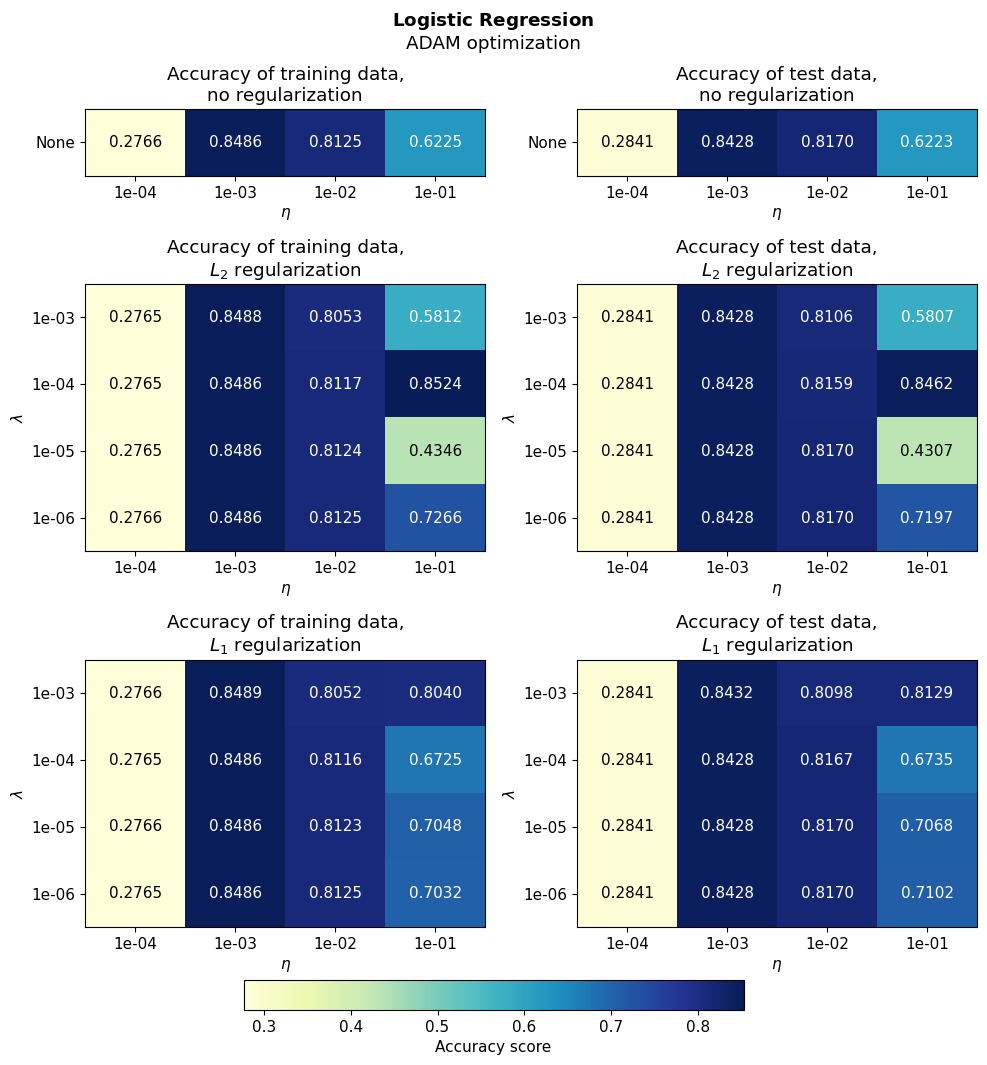

In [ ]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)


# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()


### **Testing different numbers of epochs and batch sizes**

**Own NN (Kjersti & Sverre)**

In [ ]:
# vary number of epochs and batch sizes for no regularization, and for L1 and L2 regularization

epochs = [20, 50, 100, 200, 500]

batch_sizes = [16, 32, 64, 128, 256]

reg_types = [None, "L1", "L2"]


# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])

# split data into training and test data
X_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)

# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# set parameters
eta = 0.01
lmb = 1e-6

# loop through regularization types, epochs, and batch sizes
for reg_type in reg_types:
    for i in range(len(epochs)):
        epoch = epochs[i]
        for j in range(len(batch_sizes)):
            batch_size = batch_sizes[j]

            # Create a new network
            nn = NeuralNetwork(
                network_input_size = input_size,
                layer_output_sizes = layer_sizes,
                activation_funcs = activation_funcs,
                activation_ders = activation_ders,
                cost_fun = cross_entropy,
                cost_der = cross_entropy_der,
                lamb = lmb,
                cost_fun_type = reg_type
            )

            # Train model using SGD and ADAM optimizer
            nn.train_SGD(
                X_train,
                t_train,
                epochs = epoch,
                learning_rate = eta,
                batch_size = batch_size,
                optimizer = "Adam"
            )

            # evaluate model on training and test data
            if reg_type == "L1":
                acc_train_matrix_L1[i, j] = accuracy(nn, X_train, t_train)
                acc_test_matrix_L1[i, j]  = accuracy(nn, X_test,  t_test)

            elif reg_type == "L2":
                acc_train_matrix_L2[i, j] = accuracy(nn, X_train, t_train)
                acc_test_matrix_L2[i, j]  = accuracy(nn, X_test,  t_test)

            else:
                acc_train_matrix_no_reg[i, j] = accuracy(nn, X_train, t_train)
                acc_test_matrix_no_reg[i, j]  = accuracy(nn, X_test,  t_test)


C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_24268\3754349059.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


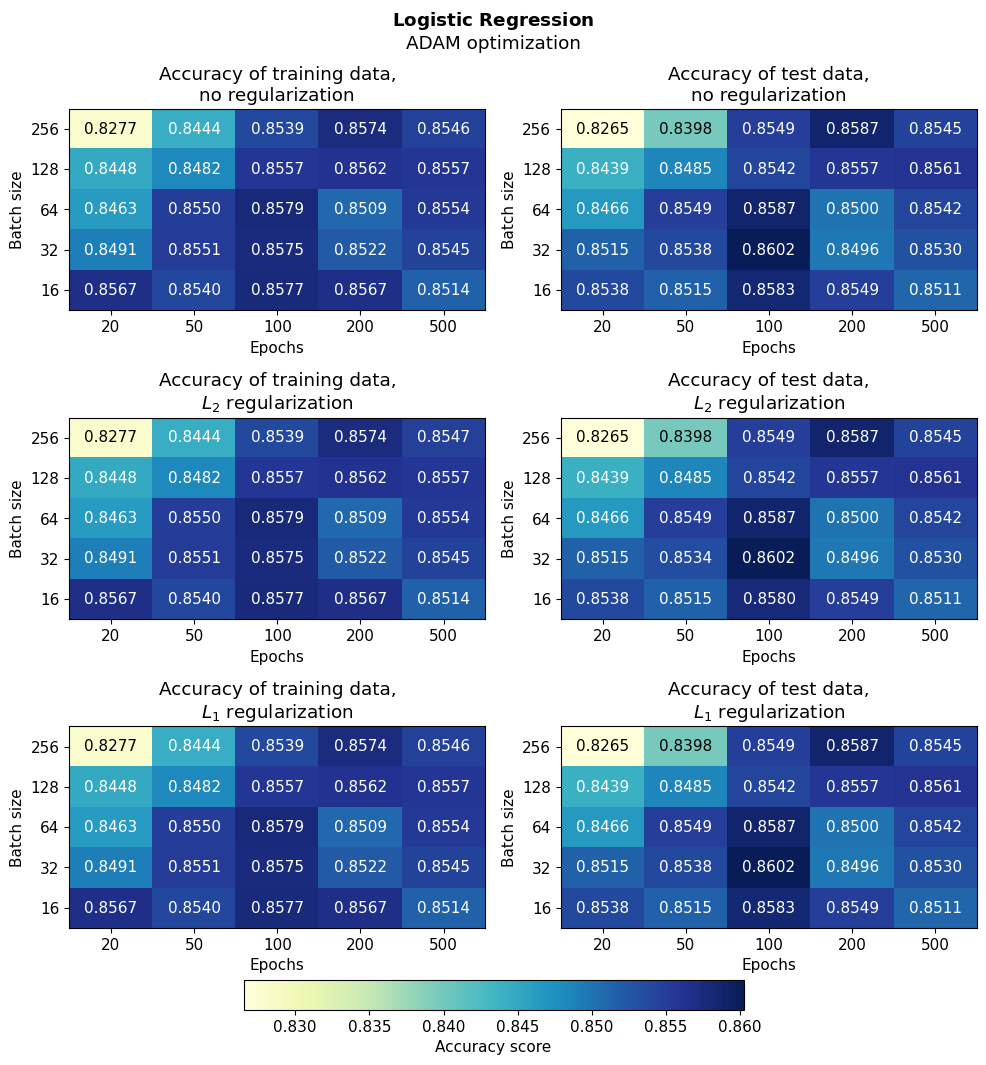

In [18]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10))#, height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg.T, acc_test_matrix_no_reg.T, acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    #im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='summer_r', vmin=vmin, vmax=vmax)
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    # Set x-ticks
    ax.set_xticks(range(len(epochs)))
    ax.set_xticklabels([f"{y}" for y in epochs])
    ax.set_xlabel("Epochs")

    # Set y-ticks
    ax.set_yticks(range(len(batch_sizes)))
    ax.set_yticklabels([f"{x}" for x in batch_sizes])
    ax.set_ylabel("Batch size")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)


# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()


**Pytorch**

In [15]:
# vary number of epochs and batch sizes for no regularization, and for L1 and L2 regularization

epochs = [20, 50, 100]

batch_sizes = [32, 64, 128]

reg_types = [None, "L1", "L2"]


# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])


# set parameters
eta = 0.01
lmb = 1e-6


# loop through regularization types, epochs, and batch sizes
for reg_type in reg_types:
    for i in range(len(epochs)):
        epoch = epochs[i]
        for j in range(len(batch_sizes)):
            batch_size = batch_sizes[j]

            np.random.seed(seed)
            torch.manual_seed(seed)

            # create loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


            # Define network dimensions
            sample, label = next(iter(train_loader))
            input_dim = sample.shape[1]
            output_dim = len(torch.unique(label))
        
        
            # Create new network
            model = WeatherNN(input_dim, output_dim)

            # Train model
            model.train_model(train_loader,
                    lr=eta,
                    epochs=epoch,
                    lmb = lmb,
                    reg_type = reg_type)

            # evaluate model on training and test data
            if reg_type == "L1":
                acc_train_matrix_L1[i, j] = model.evaluate(train_loader)
                acc_test_matrix_L1[i, j]  = model.evaluate(test_loader)

            elif reg_type == "L2":
                acc_train_matrix_L2[i, j] = model.evaluate(train_loader)
                acc_test_matrix_L2[i, j]  = model.evaluate(test_loader)

            else:
                acc_train_matrix_no_reg[i, j] = model.evaluate(train_loader)
                acc_test_matrix_no_reg[i, j]  = model.evaluate(test_loader)



C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_24268\3754349059.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


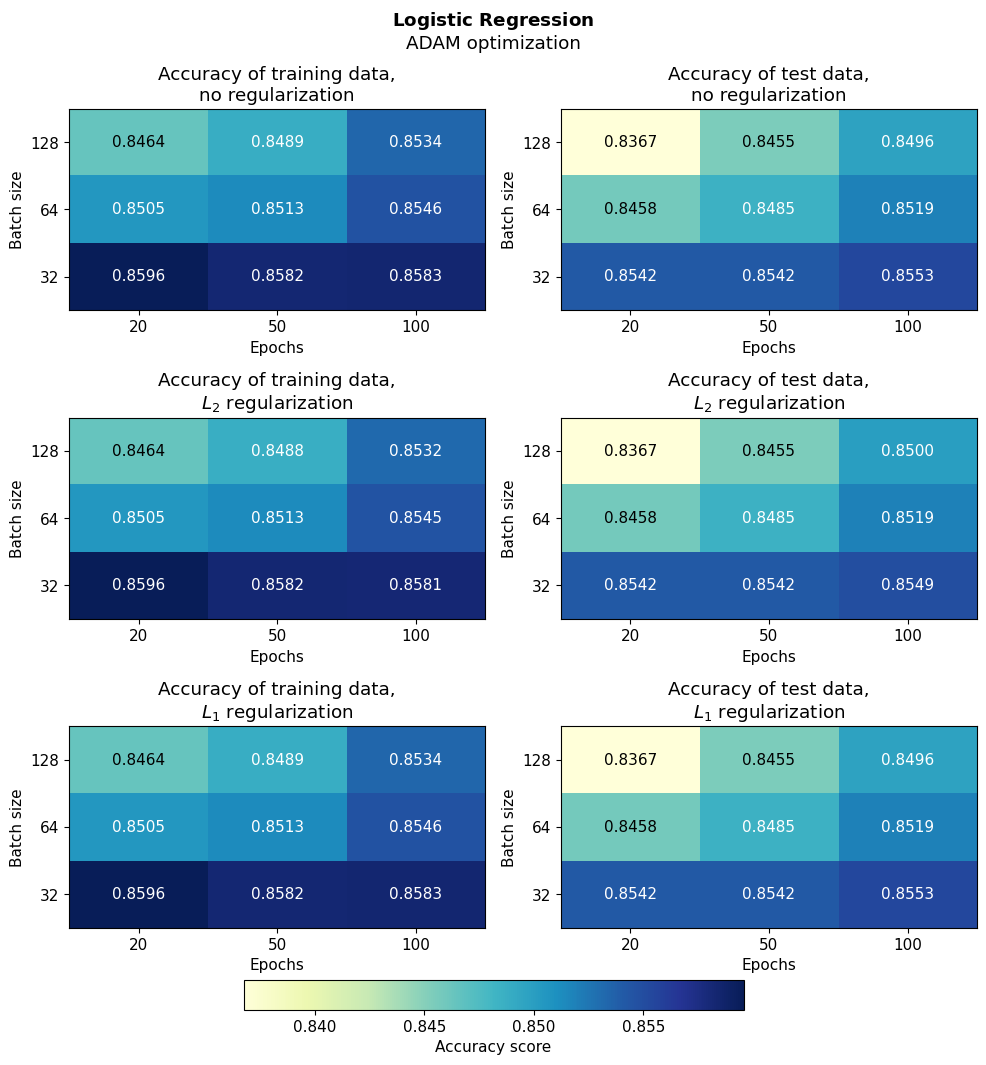

In [16]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10))#, height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg.T, acc_test_matrix_no_reg.T, acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    #im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='summer_r', vmin=vmin, vmax=vmax)
    im = ax.imshow(matrices[i], aspect='auto', origin='lower', cmap='YlGnBu', vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    # Set x-ticks
    ax.set_xticks(range(len(epochs)))
    ax.set_xticklabels([f"{y}" for y in epochs])
    ax.set_xlabel("Epochs")

    # Set y-ticks
    ax.set_yticks(range(len(batch_sizes)))
    ax.set_yticklabels([f"{x}" for x in batch_sizes])
    ax.set_ylabel("Batch size")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)


# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")

plt.suptitle(r"$\bf{Logistic\ Regression}$"+"\nADAM optimization")
fig.tight_layout()
#plt.savefig("Logistic_reg.png", bbox_inches="tight")
plt.show()
